# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


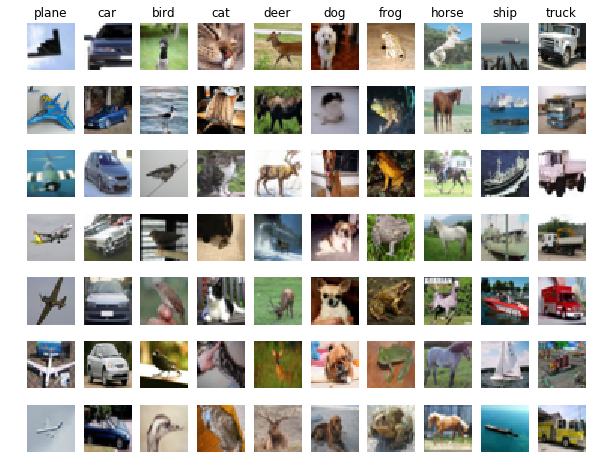

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


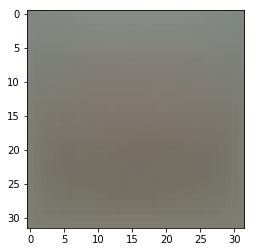

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.567014


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 28.029802 analytic: 28.029802, relative error: 2.894665e-12
numerical: -46.627974 analytic: -46.591411, relative error: 3.922333e-04
numerical: -10.849471 analytic: -10.849471, relative error: 2.656217e-11
numerical: 12.386984 analytic: 12.386984, relative error: 3.241716e-11
numerical: 17.736382 analytic: 17.736382, relative error: 1.976124e-12
numerical: -5.674749 analytic: -5.674749, relative error: 4.137513e-11
numerical: 5.675387 analytic: 5.651191, relative error: 2.136273e-03
numerical: -40.198702 analytic: -40.198702, relative error: 5.089206e-12
numerical: 9.908739 analytic: 9.908739, relative error: 1.987989e-11
numerical: 15.548199 analytic: 15.548199, relative error: 1.052508e-11
numerical: 14.652581 analytic: 14.652581, relative error: 4.147578e-12
numerical: 8.106300 analytic: 8.050256, relative error: 3.468815e-03
numerical: -45.958910 analytic: -45.931548, relative error: 2.977622e-04
numerical: 33.063784 analytic: 33.009543, relative error: 8.209243e-04
nume

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** 
It's possible on the edge where $max$ defines contribution:
$$
w^T_jx_i = w^T_{y_i}x_i + \Delta
$$
In one dimesion it will be:
$$
w_j x - w_{y_i} x = \Delta
$$
and for $x \neq 0$:
$$
w_j - w_{y_i} = \frac{\Delta}{x}
$$
In our analytical impelentation we return $\Delta = 0$. So we could stuck in one point where equation above works for all dimentions. But it's very unlikely case if it isn't attractor or saddle. 

**Is it attractor or saddle?**

It is not. Because for attractor or saddle derivation should change its sign when cross this point but we trim all negitive values there.

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.567014e+00 computed in 0.131727s
Vectorized loss: 8.567014e+00 computed in 0.016416s
difference: -0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.138757s
Vectorized loss and gradient: computed in 0.004362s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 782.853321
iteration 100 / 1500: loss 284.673944
iteration 200 / 1500: loss 106.860644
iteration 300 / 1500: loss 45.877533
iteration 400 / 1500: loss 19.100031
iteration 500 / 1500: loss 10.864671
iteration 600 / 1500: loss 6.151106
iteration 700 / 1500: loss 5.493499
iteration 800 / 1500: loss 5.672912
iteration 900 / 1500: loss 4.586462
iteration 1000 / 1500: loss 6.071684
iteration 1100 / 1500: loss 9.005899
iteration 1200 / 1500: loss 5.147316
iteration 1300 / 1500: loss 6.301812
iteration 1400 / 1500: loss 3.827235
That took 1.031156s


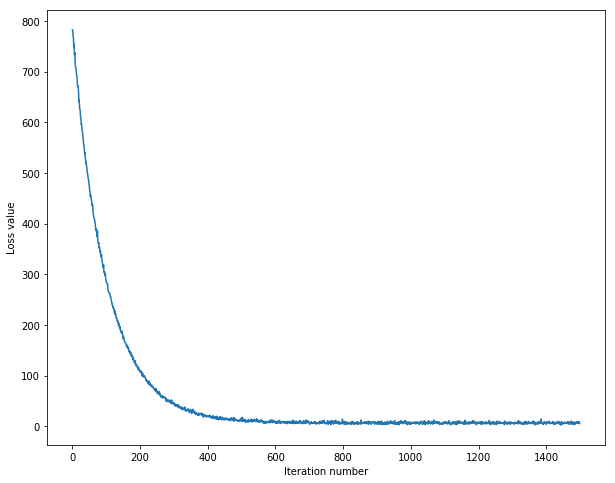

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.319490
validation accuracy: 0.326000


In [16]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
#learning_rates = [1e-7, 5e-5]
learning_rates = np.logspace(-9, -6, 10)
#regularization_strengths = [2.5e4, 5e4]
regularization_strengths = np.logspace(3, 6, 10)

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        print('\n#')
        print('learning_rate', learning_rate)
        print('regularization_strength', regularization_strength)
        print('#')
        svm = LinearSVM()
        svm.train(X_train, y_train, 
                  learning_rate=learning_rate, 
                  reg=regularization_strength,
                  num_iters=1500, 
                  verbose=True,
                 )
        trained_accuracy = np.mean(y_train == svm.predict(X_train))
        val_accuracy = np.mean(y_val == svm.predict(X_val))        
        results[(
            learning_rate, regularization_strength,
        )] = (
            trained_accuracy, 
            val_accuracy,
        )
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
#for lr, reg in sorted(results, key=lambda (lr, reg): results[(lr, reg)][1]):
for lr, reg in sorted(results, key=lambda el: results[(el[0], el[1])][1]):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


#
learning_rate 1e-09
regularization_strength 1000.0
#
iteration 0 / 1500: loss 64.833380
iteration 100 / 1500: loss 48.957176
iteration 200 / 1500: loss 45.531260
iteration 300 / 1500: loss 53.777100
iteration 400 / 1500: loss 46.519980
iteration 500 / 1500: loss 48.552151
iteration 600 / 1500: loss 47.800202
iteration 700 / 1500: loss 62.031551
iteration 800 / 1500: loss 49.011444
iteration 900 / 1500: loss 51.168452
iteration 1000 / 1500: loss 44.970302
iteration 1100 / 1500: loss 58.081700
iteration 1200 / 1500: loss 41.840282
iteration 1300 / 1500: loss 51.623285
iteration 1400 / 1500: loss 45.732707

#
learning_rate 1e-09
regularization_strength 2154.43469003
#
iteration 0 / 1500: loss 101.997140
iteration 100 / 1500: loss 81.971086
iteration 200 / 1500: loss 76.510043
iteration 300 / 1500: loss 93.149478
iteration 400 / 1500: loss 80.973767
iteration 500 / 1500: loss 91.497993
iteration 600 / 1500: loss 83.957239
iteration 700 / 1500: loss 78.617993
iteration 800 / 1500: loss 8


#
learning_rate 2.15443469003e-09
regularization_strength 10000.0
#
iteration 0 / 1500: loss 327.070547
iteration 100 / 1500: loss 317.271533
iteration 200 / 1500: loss 328.989704
iteration 300 / 1500: loss 314.726651
iteration 400 / 1500: loss 314.020640
iteration 500 / 1500: loss 320.677535
iteration 600 / 1500: loss 297.245805
iteration 700 / 1500: loss 294.656648
iteration 800 / 1500: loss 300.315885
iteration 900 / 1500: loss 304.262245
iteration 1000 / 1500: loss 290.671293
iteration 1100 / 1500: loss 288.838329
iteration 1200 / 1500: loss 292.709178
iteration 1300 / 1500: loss 275.362955
iteration 1400 / 1500: loss 288.607717

#
learning_rate 2.15443469003e-09
regularization_strength 21544.3469003
#
iteration 0 / 1500: loss 694.457863
iteration 100 / 1500: loss 665.419153
iteration 200 / 1500: loss 666.440069
iteration 300 / 1500: loss 649.044859
iteration 400 / 1500: loss 627.799231
iteration 500 / 1500: loss 616.176827
iteration 600 / 1500: loss 608.837319
iteration 700 / 150

iteration 1200 / 1500: loss 503.508414
iteration 1300 / 1500: loss 468.292150
iteration 1400 / 1500: loss 427.053413

#
learning_rate 4.64158883361e-09
regularization_strength 100000.0
#
iteration 0 / 1500: loss 3065.395566
iteration 100 / 1500: loss 2542.889420
iteration 200 / 1500: loss 2108.885560
iteration 300 / 1500: loss 1747.513156
iteration 400 / 1500: loss 1464.090350
iteration 500 / 1500: loss 1208.912830
iteration 600 / 1500: loss 1002.611266
iteration 700 / 1500: loss 838.157529
iteration 800 / 1500: loss 694.715648
iteration 900 / 1500: loss 578.835964
iteration 1000 / 1500: loss 478.590798
iteration 1100 / 1500: loss 397.007820
iteration 1200 / 1500: loss 331.558656
iteration 1300 / 1500: loss 280.991985
iteration 1400 / 1500: loss 229.106688

#
learning_rate 4.64158883361e-09
regularization_strength 215443.469003
#
iteration 0 / 1500: loss 6587.727558
iteration 100 / 1500: loss 4414.320506
iteration 200 / 1500: loss 2963.475542
iteration 300 / 1500: loss 1982.410371
iter

iteration 1200 / 1500: loss 6.582578
iteration 1300 / 1500: loss 8.766583
iteration 1400 / 1500: loss 4.743837

#
learning_rate 1e-08
regularization_strength 1000000.0
#
iteration 0 / 1500: loss 30614.905997
iteration 100 / 1500: loss 542.688804
iteration 200 / 1500: loss 16.911735
iteration 300 / 1500: loss 7.182668
iteration 400 / 1500: loss 7.508551
iteration 500 / 1500: loss 7.397243
iteration 600 / 1500: loss 6.493860
iteration 700 / 1500: loss 7.612684
iteration 800 / 1500: loss 9.726118
iteration 900 / 1500: loss 7.040005
iteration 1000 / 1500: loss 6.808124
iteration 1100 / 1500: loss 7.678135
iteration 1200 / 1500: loss 8.750300
iteration 1300 / 1500: loss 6.408592
iteration 1400 / 1500: loss 8.602407

#
learning_rate 2.15443469003e-08
regularization_strength 1000.0
#
iteration 0 / 1500: loss 60.350453
iteration 100 / 1500: loss 49.793431
iteration 200 / 1500: loss 50.981099
iteration 300 / 1500: loss 51.079504
iteration 400 / 1500: loss 41.558647
iteration 500 / 1500: loss 52

iteration 1200 / 1500: loss 46.783016
iteration 1300 / 1500: loss 53.222796
iteration 1400 / 1500: loss 45.353821

#
learning_rate 4.64158883361e-08
regularization_strength 4641.58883361
#
iteration 0 / 1500: loss 166.234036
iteration 100 / 1500: loss 139.256369
iteration 200 / 1500: loss 134.699303
iteration 300 / 1500: loss 123.528637
iteration 400 / 1500: loss 109.486148
iteration 500 / 1500: loss 98.541286
iteration 600 / 1500: loss 92.314928
iteration 700 / 1500: loss 87.136840
iteration 800 / 1500: loss 78.124814
iteration 900 / 1500: loss 69.731029
iteration 1000 / 1500: loss 63.297119
iteration 1100 / 1500: loss 60.523783
iteration 1200 / 1500: loss 55.280865
iteration 1300 / 1500: loss 49.241309
iteration 1400 / 1500: loss 43.239408

#
learning_rate 4.64158883361e-08
regularization_strength 10000.0
#
iteration 0 / 1500: loss 324.206626
iteration 100 / 1500: loss 265.142829
iteration 200 / 1500: loss 219.036906
iteration 300 / 1500: loss 181.684588
iteration 400 / 1500: loss 15


#
learning_rate 1e-07
regularization_strength 46415.8883361
#
iteration 0 / 1500: loss 1441.164969
iteration 100 / 1500: loss 223.373494
iteration 200 / 1500: loss 41.898236
iteration 300 / 1500: loss 13.262859
iteration 400 / 1500: loss 8.065770
iteration 500 / 1500: loss 5.525590
iteration 600 / 1500: loss 6.235958
iteration 700 / 1500: loss 7.163839
iteration 800 / 1500: loss 7.319377
iteration 900 / 1500: loss 5.651439
iteration 1000 / 1500: loss 5.925085
iteration 1100 / 1500: loss 6.286843
iteration 1200 / 1500: loss 9.211727
iteration 1300 / 1500: loss 8.515094
iteration 1400 / 1500: loss 5.465746

#
learning_rate 1e-07
regularization_strength 100000.0
#
iteration 0 / 1500: loss 3074.422271
iteration 100 / 1500: loss 59.418626
iteration 200 / 1500: loss 10.035197
iteration 300 / 1500: loss 7.267869
iteration 400 / 1500: loss 9.654999
iteration 500 / 1500: loss 4.916139
iteration 600 / 1500: loss 10.307708
iteration 700 / 1500: loss 6.079961
iteration 800 / 1500: loss 5.896498
i

iteration 300 / 1500: loss 9.259405
iteration 400 / 1500: loss 10.643613
iteration 500 / 1500: loss 13.667105
iteration 600 / 1500: loss 13.777511
iteration 700 / 1500: loss 11.184335
iteration 800 / 1500: loss 10.587437
iteration 900 / 1500: loss 11.051654
iteration 1000 / 1500: loss 10.300140
iteration 1100 / 1500: loss 14.158866
iteration 1200 / 1500: loss 12.088782
iteration 1300 / 1500: loss 11.566512
iteration 1400 / 1500: loss 10.156322

#
learning_rate 2.15443469003e-07
regularization_strength 1000000.0
#
iteration 0 / 1500: loss 30590.423077
iteration 100 / 1500: loss 11.661158
iteration 200 / 1500: loss 13.530431
iteration 300 / 1500: loss 14.388303
iteration 400 / 1500: loss 13.480567
iteration 500 / 1500: loss 14.778438
iteration 600 / 1500: loss 13.571175
iteration 700 / 1500: loss 8.933425
iteration 800 / 1500: loss 11.055628
iteration 900 / 1500: loss 12.103804
iteration 1000 / 1500: loss 8.749140
iteration 1100 / 1500: loss 19.985626
iteration 1200 / 1500: loss 13.15510

iteration 400 / 1500: loss 15.777940
iteration 500 / 1500: loss 30.912810
iteration 600 / 1500: loss 7.486371
iteration 700 / 1500: loss 9.352134
iteration 800 / 1500: loss 23.736924
iteration 900 / 1500: loss 16.601065
iteration 1000 / 1500: loss 11.189711
iteration 1100 / 1500: loss 18.264150
iteration 1200 / 1500: loss 5.736198
iteration 1300 / 1500: loss 27.348007
iteration 1400 / 1500: loss 14.075756

#
learning_rate 1e-06
regularization_strength 4641.58883361
#
iteration 0 / 1500: loss 158.861290
iteration 100 / 1500: loss 46.844650
iteration 200 / 1500: loss 21.543008
iteration 300 / 1500: loss 10.207120
iteration 400 / 1500: loss 13.780347
iteration 500 / 1500: loss 18.567166
iteration 600 / 1500: loss 18.452819
iteration 700 / 1500: loss 11.960206
iteration 800 / 1500: loss 12.107951
iteration 900 / 1500: loss 10.258443
iteration 1000 / 1500: loss 19.660029
iteration 1100 / 1500: loss 15.299332
iteration 1200 / 1500: loss 46.726033
iteration 1300 / 1500: loss 14.875922
iterati

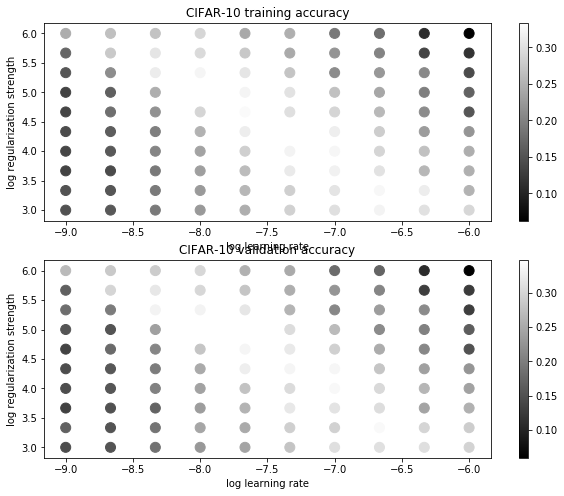

In [17]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [18]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.343000


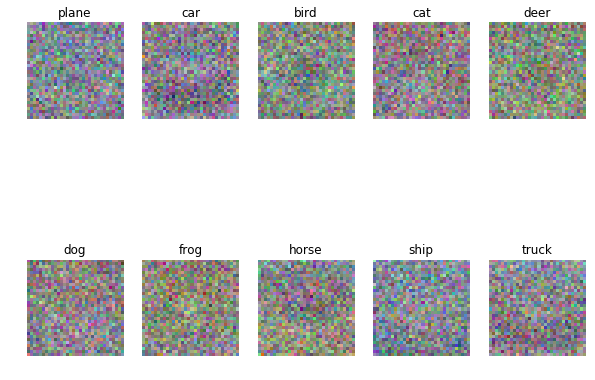

In [19]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** 
*Weights look noisy and the reason of it because we haven't done a lot of iterations. So lets try to test this hypothesis:*

In [20]:
best_options = sorted(results, key=lambda el: results[(el[0], el[1])][1])[-1]
learning_rate, regularization_strength = best_options
svm = LinearSVM()
svm.train(X_train, y_train, 
          learning_rate=learning_rate, 
          reg=regularization_strength,
          num_iters=15000, 
          verbose=True,
         )
trained_accuracy = np.mean(y_train == svm.predict(X_train))
val_accuracy = np.mean(y_val == svm.predict(X_val))   


iteration 0 / 15000: loss 3112.457272
iteration 100 / 15000: loss 1309.997003
iteration 200 / 15000: loss 553.857579
iteration 300 / 15000: loss 238.248660
iteration 400 / 15000: loss 102.525016
iteration 500 / 15000: loss 44.952571
iteration 600 / 15000: loss 22.556887
iteration 700 / 15000: loss 12.347826
iteration 800 / 15000: loss 8.137193
iteration 900 / 15000: loss 9.904574
iteration 1000 / 15000: loss 7.420480
iteration 1100 / 15000: loss 6.052271
iteration 1200 / 15000: loss 7.344525
iteration 1300 / 15000: loss 3.740679
iteration 1400 / 15000: loss 4.788720
iteration 1500 / 15000: loss 8.349595
iteration 1600 / 15000: loss 6.769541
iteration 1700 / 15000: loss 5.049936
iteration 1800 / 15000: loss 5.759028
iteration 1900 / 15000: loss 8.040454
iteration 2000 / 15000: loss 8.027323
iteration 2100 / 15000: loss 7.004320
iteration 2200 / 15000: loss 6.886071
iteration 2300 / 15000: loss 7.800039
iteration 2400 / 15000: loss 5.383136
iteration 2500 / 15000: loss 7.491668
iteration

linear SVM on raw pixels final test set accuracy: 0.328000


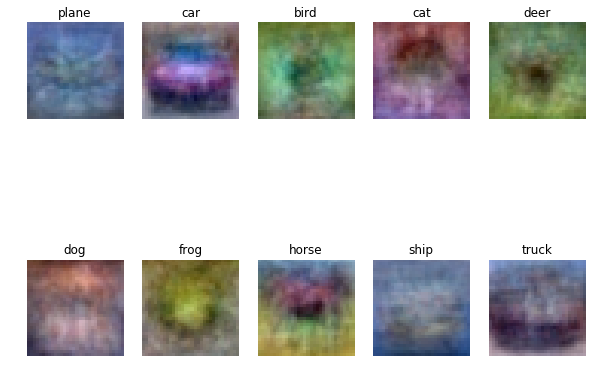

In [22]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
    
y_test_pred = svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

As we could see after 15000 iteration we have much smoother looking weights. But what looks interesting on test set we got less accuracy. So it seems somehow more iteration overfit our model.